In [25]:
#Import
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
from joblib import dump, load
import time
import joblib as joblib
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import (cross_val_predict,
                                        cross_validate,
                                        learning_curve,
                                        ShuffleSplit,
                                        train_test_split,
                                        GridSearchCV,

                                   )
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression,  ElasticNet
from sklearn.neural_network import MLPRegressor
from scipy.stats import pearsonr,stats

In [26]:
#import inner training data
file_path = 'inner_Training.xlsx'
data = pd.read_excel(file_path, header=0).apply(pd.to_numeric, errors='coerce')
selected_columns = ['TC', 'TG', 'HDL-C', 'Age', 'LDL-C', 'Gender']
data = data[selected_columns]
#statistics analysis
summary_statistics = data.describe().loc[['50%', '25%', '75%']]
gender_stats = data['Gender'].value_counts(normalize=True) * 100

#output
print("Statistic results of rawdata ：")
print(summary_statistics)
print("\n'Gender'Line：")
print("Total Counts-{}，Male:{:.2f}%".format(data['Gender'].sum(), gender_stats[1]))


Statistic results of rawdata ：
         TC      TG  HDL-C   Age   LDL-C  Gender
50%  178.66  135.51  43.31  57.0  116.78     1.0
25%  143.85   93.88  35.58  46.0   85.07     1.0
75%  207.66  200.17  51.82  66.0  141.53     2.0

'Gender'Line：
Total Counts-161798，Male:52.90%


In [28]:

# First Preprocessing
features_to_check_duplicates = ['TC', 'TG', 'HDL-C']
# delete the duplicated data
data_without_duplicates = data.drop_duplicates(subset=features_to_check_duplicates, keep='first')

In [46]:

summary_statistics = data_without_duplicates.describe().loc[['50%', '25%', '75%']]
gender_stats = data_without_duplicates['Gender'].value_counts(normalize=True) * 100


print("Baseline for inner data")
print(summary_statistics)
print("Male:")
print(gender_stats[1])
gender_count = (data_without_duplicates['Gender'] == 1.0).sum()
print("Counts：", gender_count)



Baseline for inner data
         TC      TG  HDL-C   Age   LDL-C  Gender
50%  178.66  135.51  43.31  57.0  116.78     1.0
25%  143.85   93.88  35.58  46.0   85.07     1.0
75%  208.04  200.17  52.20  66.0  141.53     2.0
Male:
52.882863916374525
Counts： 57774


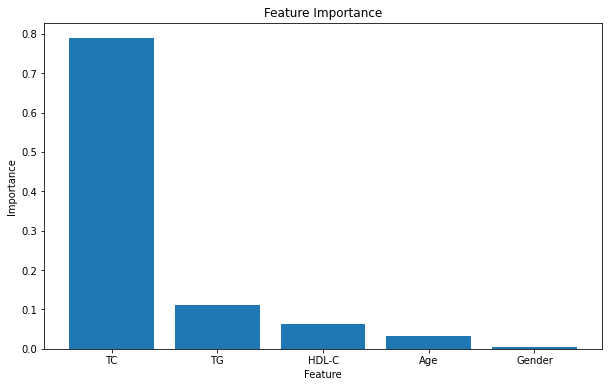

In [17]:
#Feature importance rate by RandomForestRegressor(MDI)
X = data[['TC', 'TG', 'HDL-C', 'Age', 'Gender']].values
y = data['LDL-C'].values

# 初始化随机森林回归模型
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Training model
rf.fit(X, y)


feature_importances = rf.feature_importances_

# Creating Bar Charts
plt.figure(figsize=(10, 6))
plt.bar(['TC', 'TG', 'HDL-C', 'Age', 'Gender'], feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
#plt.savefig("MDI.png",dpi=300) # if need 
plt.show()


In [21]:
reg_x_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21850 entries, 60600 to 88196
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TC      21850 non-null  float64
 1   TG      21850 non-null  float64
 2   HDL-C   21850 non-null  float64
 3   Age     21850 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 853.5 KB


In [18]:
# delete the ‘Gender’ data
data_without_duplicates.drop(columns=['Gender'], inplace=True)

#Data_Split
reg_x_train, reg_x_test, reg_y_train, reg_y_test = train_test_split(
    data_without_duplicates.drop(['LDL-C'], axis=1),  # Features
    data_without_duplicates['LDL-C'],  # Target variable
    test_size=0.2,
    random_state=42
)


/tmp/ipykernel_5232/1037141262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_without_duplicates.drop(columns=['Gender'], inplace=True)


In [47]:
# duplicate 5 times for all data
# K-S-test 
statistic, p_value = stats.kstest(data_without_duplicates['TC'], 'norm')

print( statistic )
print( p_value )

alpha = 0.05  
if p_value > alpha:
    print("follow")
else:
    print("not follow")


1.0
0.0
not follow


/tmp/ipykernel_5232/330292345.py:3: DeprecationWarning: Please import `kstest` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  statistic, p_value = stats.kstest(data_without_duplicates['TC'], 'norm')


In [48]:

#import scaler(Standard Scaler)

scaler_filename = 'scaler_20240224.joblib'
scaler = joblib.load(scaler_filename)
reg_x_train_scaled = scaler.fit_transform(reg_x_train)
reg_x_test_scaled = scaler.fit_transform(reg_x_test)

In [ ]:
#Hyper - Training && Select the superior model
best_models = {}
models_to_tune = {
   'Linear Regression Models': [
       {'model': LinearRegression(), 'params': {
           'fit_intercept': [True, False],
       }}
   ],
   'KNN Model': [
       {'model': KNeighborsRegressor(), 'params': {
           'n_neighbors': range(1, 21),
           'weights': ['uniform', 'distance'],
           'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [10, 20, 30, 40],
           'p': [1, 2],
           'metric': ['euclidean', 'manhattan'],

       }}
   ],
    'DecisionTree Model': [
       {'model': DecisionTreeRegressor(), 'params': {
                'min_samples_split': list(range(1, 11)),
                'min_samples_leaf': list(range(1, 11)),
	         	 'max_features':[None, 'sqrt', 'log2',1.0]
       }}
   ],
   'RandomForest Model': [
       {'model': RandomForestRegressor(), 'params': {
           'n_estimators': [10,50, 100, 150],
           'max_depth': [None, 10, 20, 30],
           'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 2],
           'max_features': [None, 'sqrt', 'log2',1.0]
       }}
   ],
   'XGBoost Model': [
       {'model': GradientBoostingRegressor(), 'params': {
           'n_estimators': [50, 100, 150],
           'max_depth': [3, 5, 7],
           'learning_rate': [0.01, 0.1, 0.3],
           'subsample': [0.5, 0.7, 1.0],
           'max_features':['sqrt', 'log2',None]
       }}
   ],
    'MLP Model': [
        {'model': MLPRegressor(), 'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'alpha': [0.0001, 0.001, 0.01],
            'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'sgd', 'adam'],
            'learning_rate': ['constant', 'invscaling', 'adaptive']
,
            'max_iter':[1000]
        }}
    ]
}

for model_category, models in models_to_tune.items():
    for model_info in models:
        model = model_info['model']
        param_grid = model_info['params']

        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
        grid_search.fit(reg_x_train_scaled, reg_y_train)
        # 进行预测
        y_pred = grid_search.predict(reg_x_test_scaled)
        
        # 计算评价指标
        pearson_corr, _ = pearsonr(reg_y_test, y_pred)
        mae = mean_absolute_error(reg_y_test, y_pred)
        mse = mean_squared_error(reg_y_test, y_pred)
        
        print(f"Model: {model_category}, Score: {grid_search.best_score_}, Pearson Correlation: {pearson_corr}, MAE: {mae}, MSE: {mse}")
        
        best_models[(model_category, str(model))] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'pearson_corr': pearson_corr,
            'mae': mae,
            'mse': mse
        }
    
        print('----------------')
#Drop the output
with open('model_results_standard.txt', 'w') as file:
        for key, value in best_models.items():
            file.write(f"{key}:\nBest Parameters: {value['best_params']}\nBest Score (r2): {value['best_score']}\nPearson Correlation: {value['pearson_corr']}\nMAE: {value['mae']}\nMSE: {value['mse']}\n\n")

# Print output
for key, value in best_models.items():
    print(f"{key}:\nBest Parameters: {value['best_params']}\nBest Score (r2): {value['best_score']}\nPearson Correlation: {value['pearson_corr']}\n")


In [ ]:
# load the best parameterss
best_models_to_train = {
    ('Linear Regression Models', 'LinearRegression()'): 
            LinearRegression(fit_intercept=True),
    ('KNN Model', 'KNeighborsRegressor()'): 
            KNeighborsRegressor(algorithm='ball_tree', leaf_size=20, metric='euclidean', n_neighbors=20, p=1, weights='uniform'),
    ('DecisionTree Model', 'DecisionTreeRegressor()'): 
            DecisionTreeRegressor(max_features=1.0, min_samples_leaf=10, min_samples_split=6),
    ('RandomForest Model', 'RandomForestRegressor()'): 
            RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, n_estimators=150),
    ('XGBoost Model', 'GradientBoostingRegressor()'): 
            GradientBoostingRegressor(learning_rate=0.1, max_depth=5, max_features=None, n_estimators=100, subsample=1.0),
    ('MLP Model', 'MLPRegressor()'): 
            MLPRegressor(activation='logistic', alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate='adaptive', solver='lbfgs', max_iter=1000)
}



In [ ]:
# retraining and drop the model_trained
for model_key, model_instance in best_models_to_train.items():
    model_instance.fit(reg_x_train_scaled, reg_y_train)
    model_filename = f"{model_key[0]}_{datetime.now().strftime('%Y%m%d%H%M%S')}.joblib"
    dump(model_instance, model_filename)
    print(f"Model '{model_key[0]}' retrained and saved as '{model_filename}'")

In [ ]:

# import the model which was trained
model_filenames = [
    'Linear Regression Models_20240301212625.joblib',
    'KNN Model_20240301212625.joblib',
    'DecisionTree Model_20240301212626.joblib',
    'RandomForest Model_20240301212640.joblib',
    'XGBoost Model_20240301212649.joblib',
    'MLP Model_20240301220642.joblib'
]


In [ ]:
# reload the model
for model_filename in model_filenames:
    model = joblib.load(model_filename)
    
    model_name = model_filename.split('_')[0]
    print(f"Model: {model_name}")
    
    # check the para
    if isinstance(model, RandomForestRegressor):
        print("Parameters:")
        print(f"max_depth: {model.max_depth}")
        print(f"max_features: {model.max_features}")
        print(f"min_samples_leaf: {model.min_samples_leaf}")
        print(f"min_samples_split: {model.min_samples_split}")
        print(f"n_estimators: {model.n_estimators}")
    elif isinstance(model, GradientBoostingRegressor):
        print("Parameters:")
        print(f"learning_rate: {model.learning_rate}")
        print(f"max_depth: {model.max_depth}")
        print(f"max_features: {model.max_features}")
        print(f"n_estimators: {model.n_estimators}")
        print(f"subsample: {model.subsample}")
    elif isinstance(model, MLPRegressor):
        print("Parameters:")
        print(f"activation: {model.activation}")
        print(f"alpha: {model.alpha}")
        print(f"hidden_layer_sizes: {model.hidden_layer_sizes}")
        print(f"learning_rate: {model.learning_rate}")
        print(f"solver: {model.solver}")
        print(f"max_iter: {model.max_iter}")
    elif isinstance(model, (LinearRegression, KNeighborsRegressor, DecisionTreeRegressor)):
        print("No specific parameters")
    else:
        print("Unknown")

    print("\n")

In [ ]:
#get the predictions
predictions = {}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

#  the plot setting
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

# common para
common_params = {
    "X": reg_x_train_scaled,
    "y": reg_y_train,
    "cv": 5,
    "score_type": "both",
    "n_jobs": 24,

}

for ax, ((model_name, model_string), model_instance) in zip(axs.flatten(), best_models_to_train.items()):
    display = LearningCurveDisplay.from_estimator(model_instance, ax=ax, **common_params)
    ax.set_title(f"Learning Curve for {model_name}")
    ax.legend(["Training Score", "Test Score"], loc="best")    


plt.tight_layout()
plt.show()
#plt.savefig("learning_curves.png")

In [ ]:
for model_filename in model_filenames:
    
    model = joblib.load(model_filename)
    
    y_pred = model.predict(reg_x_test_scaled)
    
    model_name = model_filename.split('_')[0]
    
    predictions[f"y_pred_{model_name}"] = y_pred


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr

fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

for idx, (pred_name, y_pred) in enumerate(predictions.items()):
    row_idx = idx // 3
    col_idx = idx % 3
    
    PredictionErrorDisplay.from_predictions(
        reg_y_test,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=21850,
        ax=axs[row_idx, col_idx],
        random_state=0,
    )
    axs[row_idx, col_idx].set_title(pred_name.replace("y_pred_", ""))
    axs[row_idx, col_idx].set_xticks(np.arange(0, 401 , 100))
    axs[row_idx, col_idx].set_yticks(np.arange(0, 401 , 100))

    r2 = r2_score(reg_y_test, y_pred)
    pearson_corr, _ = pearsonr(reg_y_test, y_pred)
    mse = mean_squared_error(reg_y_test, y_pred)
    

    axs[row_idx, col_idx].text(0.05, 0.95, f"R²={r2:.3f}\nPCC={pearson_corr:.3f}\nMSE={mse:.3f}", 
                               transform=axs[row_idx, col_idx].transAxes, verticalalignment='top', 
                               bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.7})


fig.suptitle("Plotting cross-validated predictions(1)")
plt.tight_layout()

plt.show()
#plt.savefig("Plotting cross-validated predictions(1).png")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr

fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

for idx, (pred_name, y_pred) in enumerate(predictions.items()):
    row_idx = idx // 3
    col_idx = idx % 3
    
    PredictionErrorDisplay.from_predictions(
        reg_y_test,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=21850,
        ax=axs[row_idx, col_idx],
        random_state=0,
    )
    axs[row_idx, col_idx].set_title(pred_name.replace("y_pred_", ""))
    axs[row_idx, col_idx].set_xticks(np.arange(0, 401 , 100))
    r2 = r2_score(reg_y_test, y_pred)
    pearson_corr, _ = pearsonr(reg_y_test, y_pred)
    mse = mean_squared_error(reg_y_test, y_pred)
    
    axs[row_idx, col_idx].text(0.05, 0.95, f"R²={r2:.3f}\nPCC={pearson_corr:.3f}\nMSE={mse:.3f}", 
                               transform=axs[row_idx, col_idx].transAxes, verticalalignment='top', 
                               bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.7})

fig.suptitle("Plotting cross-validated predictions(2)")
plt.tight_layout()
plt.show()

#plt.savefig("Plotting cross-validated predictions(2).png")




In [ ]:
#external data
out_path = 'output.xlsx'
data_out = pd.read_excel(out_path, header=0).apply(pd.to_numeric, errors='coerce')
data_out = data_out[['TC', 'TG', 'HDL', 'AGE', 'LDL']]


In [49]:
#external dataset baseline
file_path = 'output.xlsx'
data_out = pd.read_excel(file_path, header=0).apply(pd.to_numeric, errors='coerce')
selected_columns = ['TC', 'TG', 'HDL', 'AGE', 'LDL', 'gender']
data_out = data_out[selected_columns]

summary_statistics = data_out.describe().loc[['50%', '25%', '75%']]

gender_stats = data_out['gender'].value_counts(normalize=True) * 100

#output
print("Statistic results of rawdata ：")
print(summary_statistics)
print("\n'Gender'Line：")
print(gender_stats[1])


Statistic results of rawdata ：
         TC      TG    HDL   AGE     LDL  gender
50%  184.46  138.17  41.76  58.0  110.21     1.0
25%  148.88   97.43  35.19  49.0   80.05     1.0
75%  214.23  201.05  49.50  67.0  136.89     2.0

'Gender'Line：
51.144063635470886


In [50]:
X = data_out.drop(['LDL'], axis=1)  
y = data_out['LDL']  

In [ ]:
# apply the same scaler for external data
X_scaled = scaler.fit_transform(X)

In [ ]:
out_predictions = {}

In [ ]:
for model_filename in model_filenames:
    model = joblib.load(model_filename)
    
    out_y_pred = model.predict(X_scaled)
    
    model_name = model_filename.split('_')[0]
    
    out_predictions[f"y_pred_{model_name}"] = out_y_pred



In [ ]:
data_out_1 = pd.read_excel(file_path, header=0).apply(pd.to_numeric, errors='coerce')

In [ ]:
for model_name, preds in out_predictions.items():
    # 将预测结果保留两位小数
    rounded_preds = [round(pred, 2) for pred in preds]
    short_model_name = model_name[7:]
    data_out_1[short_model_name] = rounded_preds


In [ ]:
data_out_1.to_excel('total_prediction.xlsx', index=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr

fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

model_names = ['Friedewald', 'Sampson', 'Martin', 'RandomForest Model', 'XGBoost Model', 'MLP Model']

for idx, model_name in enumerate(model_names):
    row_idx = idx // 3
    col_idx = idx % 3
    
    y_pred = data_out_1[model_name]
    
    PredictionErrorDisplay.from_predictions(
        data_out_1['LDL'],
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=10183,
        ax=axs[row_idx, col_idx],
        random_state=0,
    )
    axs[row_idx, col_idx].set_title(model_name)
    
    min_val = min(min(data_out_1['LDL']), min(y_pred))
    max_val = max(max(data_out_1['LDL']), max(y_pred))
    axs[row_idx, col_idx].plot([min_val, max_val], [min_val, max_val], 'k--')
    
    axs[row_idx, col_idx].set_xticks(np.arange(0, 401 , 100))
    axs[row_idx, col_idx].set_yticks(np.arange(0, 401 , 100))
    
    r2 = r2_score(data_out_1['LDL'], y_pred)
    pearson_corr, _ = pearsonr(data_out_1['LDL'], y_pred)
    mse = mean_squared_error(data_out_1['LDL'], y_pred)
    
    axs[row_idx, col_idx].text(0.05, 0.95, f"R²={r2:.3f}\nPCC={pearson_corr:.3f}\nMSE={mse:.3f}", 
                               transform=axs[row_idx, col_idx].transAxes, verticalalignment='top', 
                               bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.7})

fig.suptitle("Plotting cross-validated predictions(3)")
plt.tight_layout()
plt.show()
#plt.savefig("Plotting cross-validated predictions(3).png") 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr

fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

model_names = ['Friedewald', 'Sampson', 'Martin', 'RandomForest Model', 'XGBoost Model', 'MLP Model']

for idx, model_name in enumerate(model_names):
    row_idx = idx // 3
    col_idx = idx % 3
    
    y_pred = data_out_1[model_name]
    
    PredictionErrorDisplay.from_predictions(
        data_out_1['LDL'],
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=10183,
        ax=axs[row_idx, col_idx],
        random_state=42,
    )
    axs[row_idx, col_idx].set_title(model_name)

        
    r2 = r2_score(data_out_1['LDL'], y_pred)
    pearson_corr, _ = pearsonr(data_out_1['LDL'], y_pred)
    mse = mean_squared_error(data_out_1['LDL'], y_pred)
    
    axs[row_idx, col_idx].text(0.05, 0.15, f"R²={r2:.3f}\nPCC={pearson_corr:.3f}\nMSE={mse:.3f}", 
                               transform=axs[row_idx, col_idx].transAxes, verticalalignment='top', 
                               bbox={'boxstyle': 'round', 'facecolor': 'white', 'alpha': 0.7})

fig.suptitle("Plotting cross-validated predictions(4)")


plt.tight_layout()
plt.show()
plt.savefig("Plotting cross-validated predictions(4).png") 


In [ ]:
#sort the data
data_out_1_sorted = data_out_1.sort_values(by='TG')
data_out_1_sorted.to_excel("data_sorted_TG.xlsx", index = False)

In [ ]:
import pandas as pd
from scipy.stats import pearsonr
model_names = ['Friedewald', 'Sampson', 'Martin', 'RandomForest Model', 'XGBoost Model', 'MLP Model']
data_sorted_TG = pd.read_excel("data_sorted_TG.xlsx")
# 假设你有一个名为data_sorted_TG的DataFrame，包含了实际值和预测值
# 以及一个名为model_names的列表，对应了六个模型的名称

# 提取实际值和预测值的列
actual_column = 'LDL'
predicted_columns = model_names

# 计算皮尔逊相关系数和p值
correlation_p_values = {}
for col in predicted_columns:
    correlation_coefficient, p_value = pearsonr(data_sorted_TG[actual_column], data_sorted_TG[col])
    correlation_p_values[col] = (correlation_coefficient, "{:.5f}".format(p_value))

# 将结果转换为DataFrame
result_df = pd.DataFrame.from_dict(correlation_p_values, orient='index', columns=['Pearson correlation coefficient', 'p-value'])

print(result_df)


In [ ]:
bins = [float('-inf'), 100, 150, 200, 300, 400, float('inf')]
labels = ['>0 and <100', '>=100 and <150', '>=150 and <200', '>=200 and <300', '>=300 and <400', '>=400']

data_sorted_TG['TG_Category'] = pd.cut(data_sorted_TG['TG'], bins=bins, labels=labels)

print(data_sorted_TG)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
labels = ['>0 and <100', '>=100 and <150', '>=150 and <200', '>=200 and <300', '>=300 and <400', '>=400']

def calculate_metrics(data, target_column, model_columns):
    metrics = {}
    
    for model in model_columns:
        model_r2 = []
        model_mse = []
        model_pearson = []
        model_p_value = []
        
        for label in labels:
            subset = data[data['TG_Category'] == label]
            r2 = r2_score(subset[target_column], subset[model])
            mse = mean_squared_error(subset[target_column], subset[model])
            pearson, p_value = pearsonr(subset[target_column], subset[model])
            
            model_r2.append(r2)
            model_mse.append(mse)
            model_pearson.append(pearson)
            model_p_value.append("{:.3f}".format(p_value))
        
        metrics[model] = {
            'R2': model_r2,
            'MSE': model_mse,
            'Pearson': model_pearson,
            'p-value': model_p_value
        }
    
    return metrics

metrics = calculate_metrics(data_sorted_TG, 'LDL', models)

for model, values in metrics.items():
    print(f'Model: {model}')
    for i, label in enumerate(labels):
        print(f'{label}: R2={values["R2"][i]:.2f}, MSE={values["MSE"][i]:.2f}, Pearson={values["Pearson"][i]:.2f}, p-value={values["p-value"][i]}')
    print()


In [ ]:
import csv
output_file = "metrics_results.csv"

with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Model', 'Label', 'R2', 'MSE', 'Pearson'])
    
    for model, values in metrics.items():
        for i, label in enumerate(labels):
            writer.writerow([model, label, values["R2"][i], values["MSE"][i], values["Pearson"][i]])

print(f"Results saved to {output_file}")

In [ ]:
import matplotlib.pyplot as plt

r2_data = {model: [] for model in models}
mse_data = {model: [] for model in models}
pearson_data = {model: [] for model in models}

for model in models:
    for i, label in enumerate(labels):
        r2_data[model].append(metrics[model]['R2'][i])
        mse_data[model].append(metrics[model]['MSE'][i])
#        pearson_data[model].append(metrics[model]['Pearson'][i])

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.set_xlabel('TG Category',fontsize = 18)
ax1.set_ylabel('R2', color='tab:blue', fontsize = 18)
ax1.plot(labels, r2_data['Friedewald'], label='Friedewald', color='tab:blue')
ax1.plot(labels, r2_data['Sampson'], label='Sampson', color='tab:orange')
ax1.plot(labels, r2_data['Martin'], label='Martin', color='tab:green')
ax1.plot(labels, r2_data['RandomForest Model'], label='RandomForest Model', color='tab:red')
ax1.plot(labels, r2_data['XGBoost Model'], label='XGBoost Model', color='tab:purple')
ax1.plot(labels, r2_data['MLP Model'], label='MLP Model', color='tab:brown')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(-1, 1)
ax1.legend(loc='center left',fontsize = 15)

ax2 = ax1.twinx()  
ax2.set_ylabel('MSE', color='black',fontsize = 18)
ax2.plot(labels, mse_data['Friedewald'], label='Friedewald MSE', linestyle='dashed', color='tab:blue')
ax2.plot(labels, mse_data['Sampson'], label='Sampson MSE', linestyle='dashed', color='tab:orange')
ax2.plot(labels, mse_data['Martin'], label='Martin MSE', linestyle='dashed', color='tab:green')
ax2.plot(labels, mse_data['RandomForest Model'], label='RandomForest Model MSE', linestyle='dashed', color='tab:red')
ax2.plot(labels, mse_data['XGBoost Model'], label='XGBoost Model MSE', linestyle='dashed', color='tab:purple')
ax2.plot(labels, mse_data['MLP Model'], label='MLP Model MSE', linestyle='dashed', color='tab:brown')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 2500)

fig.tight_layout()  
#plt.savefig('lineplot.png')
plt.show()
